# Variational Autoencoders (Toy dataset)
Skeleton code from https://github.com/tudor-berariu/ann2018

## 1. Miscellaneous

In [1]:
import torch
from torch import Tensor
assert torch.cuda.is_available()

In [2]:
import matplotlib.pyplot as plt
from math import ceil

def show_images(X: torch.Tensor, nrows=3):
    ncols = int(ceil(len(X) / nrows))
    ratio = nrows / ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10 * ratio))
    for idx, img in enumerate(X):
        r, c = idx // ncols, idx % ncols
        axs[r][c].imshow(img[0].numpy(), aspect='equal', vmin=0, vmax=1, cmap='binary')
    
    for row_axs in axs:
        for ax in row_axs:
            ax.set_aspect('equal', 'box')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    fig.tight_layout()

## 2. Our dataset

torch.Size([15, 1, 4, 4])


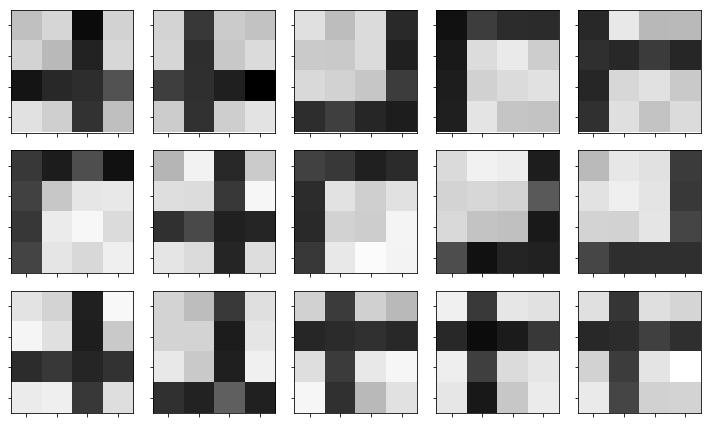

In [3]:
def get_dataset(n, idxs):
    X = torch.randn(n * 16) * .1
    X[idxs] += 1
    X = (X - X.min()) / (X.max() - X.min())
    X.clamp_(0, 1)
    X = X.reshape(n, 1, 4, 4)
    return X


n = 15
idxs = [2, 6, 8, 9, 10, 11, 14, 17, 21, 24, 25, 26, 27, 29, 35, 39, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 56, 60, 64, 68, 69, 70, 71, 72, 76, 80, 81,
        82, 83, 84, 88, 92, 98, 102, 104, 105, 106, 107, 110, 112, 113, 114,
        115, 116, 120, 124, 131, 135, 139, 140, 141, 142, 143, 147, 151, 155,
        156, 157, 158, 159, 162, 166, 168, 169, 170, 171, 174, 178, 182, 186,
        188, 189, 190, 191, 193, 196, 197, 198, 199, 201, 205, 209, 212, 213,
        214, 215, 217, 221, 225, 228, 229, 230, 231, 233, 237]


X = get_dataset(n, idxs)
show_images(X)


print(X.shape)

## 3. The Variational Auto-encoder


The encoder computes $q_{\phi}\left(z \mid x\right)$ predicting:

 - $\mu_{\phi}\left(x\right)$ and
 - $\log \sigma_{\phi}^2\left(x\right)$.
 
 
 The decoder computes $p_{\theta}\left(x \mid z\right)$.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, nz: int = 1) -> None:
        super(VAE, self).__init__()
        self.nz = nz  # The number of dimensions in the latent space
        self.encoder = nn.Sequential(nn.Linear(16, 64), nn.ReLU())
        self.mean = nn.Linear(64, nz)  # predicts the mean of p(z|x)
        self.log_var = nn.Linear(64, nz)  # predicts the log-variance of p(z|x)
        self.decoder = nn.Sequential(nn.Linear(nz, 64), nn.ReLU(),
                                     nn.Linear(64, 16))
    
    def forward(self, x):
        x = x.view(-1, 16) # Drop this if you use convolutional encoders

        # Encoding x into mu, and log-var of p(z|x)
        x = self.encoder(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
    
        # ----------------------------------------------------------------
        # TODO 1: compute z = (eps * std) + mean (reparametrization trick)
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        noise = eps * std + mean
        # ----------------------------------------------------------------

        # Decoding z into p(x|z)
        x = self.decoder(noise)
        x = torch.sigmoid(x)

        return x.view(-1, 1, 4, 4), mean, log_var
  
    def generate(self, nsamples: int = None, noise: Tensor = None) -> Tensor:
        # Generate some data
        with torch.no_grad():
            if noise is None:
                noise = torch.randn(nsamples, self.nz)      
            x = self.decoder(noise)
            x = torch.sigmoid(x)
            return x.view(-1, 1, 4, 4)

## 4. Training the model

The optimization criterion has two components.

 - the KL divergence between $q_{\phi}\left(z \mid x\right)$ and $p\left(z\right)$
   * both are diagonal gaussians, therefore we have a simple formula for the KL divergence: [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Examples)
   
 - the reconstruction loss computed using the [binary cross entropy](https://pytorch.org/docs/stable/nn.html#binary-cross-entropy)
   

In [5]:
import torch.optim as optim
import numpy as np

def train(vae: VAE, X: torch.Tensor, nsteps: int = 200000):
    bce_trace, kl_trace = [], []
    optimizer = optim.Adam(vae.parameters(), lr=.001)
  
    for step in range(nsteps):
        optimizer.zero_grad()
        rec, mean, log_var = vae(X + torch.randn_like(X) * .05)

        # -----------------------------------------------
        # TODO 2: compute the two losses (do not average)
        std = torch.exp(log_var / 2)
        bce = F.binary_cross_entropy(rec, X, reduction='sum')
        kl = 0.5 * torch.sum(std ** 2 + mean ** 2 - log_var - 1)
        # -----------------------------------------------

        (bce + kl).backward()
        optimizer.step()

        # Chestiuni pentru afișare
        bce_trace.append(bce.item())
        kl_trace.append(kl.item())
        
        if (step + 1) % 100 == 0:
            print(f"\rStep {step + 1:d}: BCE={np.mean(bce_trace):7.5f}  "
                  f"KL={np.mean(kl_trace):7.5f}", end="")
            bce_trace.clear()
            kl_trace.clear()
            if (step + 1) % 2500 == 0:
                print("")

In [6]:
%%time
vae = VAE()
train(vae, X)

Step 2500: BCE=124.08627  KL=21.40327
Step 5000: BCE=121.51171  KL=22.73478
Step 7500: BCE=118.72833  KL=23.95096
Step 10000: BCE=116.03406  KL=25.23266
Step 12500: BCE=114.52011  KL=25.78964
Step 15000: BCE=113.27066  KL=26.21569
Step 17500: BCE=113.04031  KL=26.38341
Step 20000: BCE=112.53327  KL=26.08687
Step 22500: BCE=112.09835  KL=26.53603
Step 25000: BCE=111.80955  KL=27.05710
Step 27500: BCE=111.38995  KL=27.29390
Step 30000: BCE=111.39255  KL=26.35909
Step 32500: BCE=110.91012  KL=27.30216
Step 35000: BCE=110.99902  KL=27.11818
Step 37500: BCE=111.01553  KL=26.88746
Step 40000: BCE=110.35143  KL=27.28258
Step 42500: BCE=110.58733  KL=27.05585
Step 45000: BCE=110.33013  KL=27.25576
Step 47500: BCE=110.24042  KL=27.01841
Step 50000: BCE=110.44379  KL=27.61993
Step 52500: BCE=110.90212  KL=27.00687
Step 55000: BCE=110.07556  KL=27.86644
Step 57500: BCE=110.43340  KL=27.52413
Step 60000: BCE=110.03051  KL=27.28146
Step 62500: BCE=109.90407  KL=26.81705
Step 65000: BCE=109.87070  K

## 5. Evaluating the model

### 5.1 Reconstructions

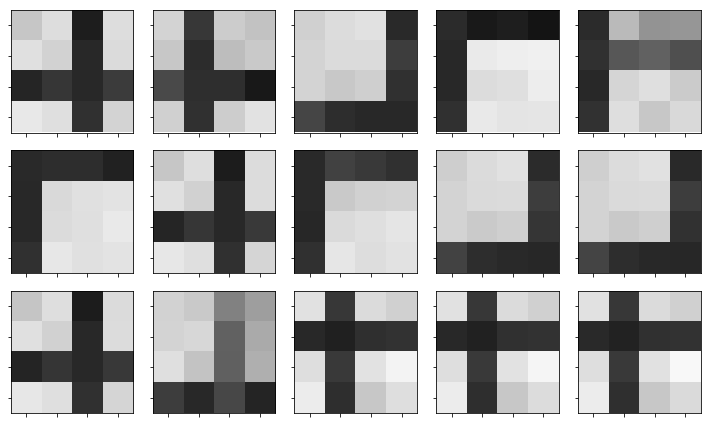

In [7]:
with torch.no_grad():
    recon, _, _ = vae(X)

show_images(recon)

### 5.2 Samples from the model

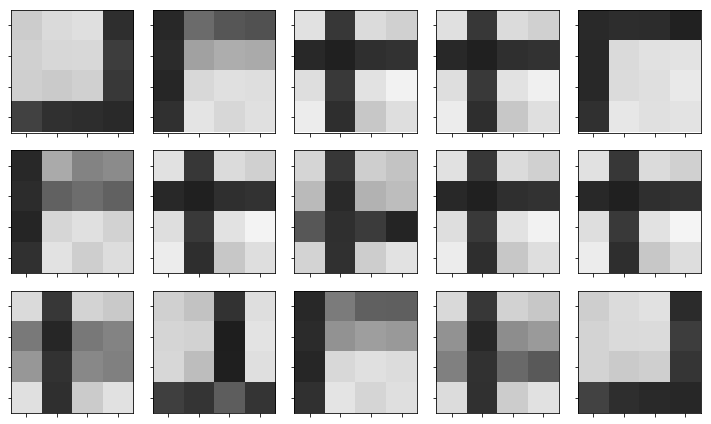

In [8]:
X_gen = vae.generate(nsamples=15)
show_images(X_gen)

### 5.3 Walk the latent space :)

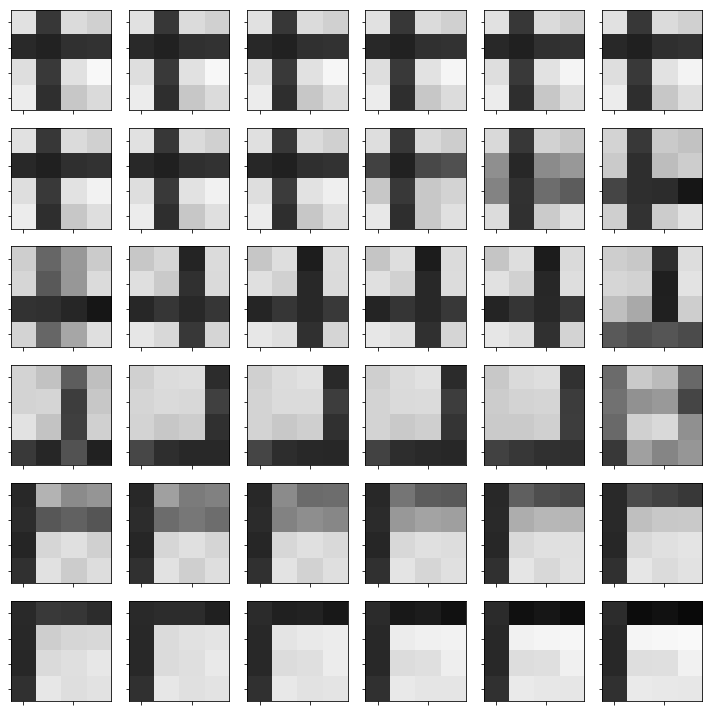

In [9]:
N = 36
noise = torch.linspace(-2, 2, N).unsqueeze(1)
X_gen = vae.generate(noise=noise)
show_images(X_gen, nrows=6)